# Inpainting Cropped Diffusion MRI using Variational Autoencoders

Variational autoencoders have been demonstrated to be powerful generative models for learning a lower-dimensional latent distribution of high dimensional data and then generating data from that distribution. This has numerous applications such as denoising documents or audio, or even generating faces and music. Its application in neuroimaging have been limited, however, due to lack of large datasets. Neuroimaging data is 3D, adding another layer of complexity.

Neuroimaging data is mired with signal artifacts induced by motion, inhomogeneties in the magnetic field, even field-of-view issues causing cropping and loss of data. In diffusion imaging, signal dropout is very common and is usually an important quality control metric that can determine whether a subject is included or not. In fact, distortion removal pipelines typically require a separate scan in the opposite phase encoding direction, which is usually not acquired due to time or funding constraints. Thus, many diffusion images contain significant distortions in brain voxels, especially near the cerebellum and frontal cortex. The presence of numerous artifacts, on top of the difficulty in acquiring subjects for a neuroimaging study, make it very challenging to compile a large clean neuroimaging dataset and test generalizable hypotheses about the brain's structure and function.

Here, we will attempt to recover lost signal due to field-of-view/cropping issues in DTI data using variational autoencoders. We will use a special type of VAE - the vector quantized VAE - to achieve this.

## Train model

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import numpy as np
import time, datetime
from Dataset import Dataset
from Models import *
from utils import *
import pickle, os


# ===============================================================
# SPECIFY THESE
# ===============================================================
batch_size = 128
max_epochs = 40
cpu_batch_load_workers = 8
log_every_num_batches = 40
model_save_path = 'models/vqvae/'
input_shape = (1,96,96,64)
num_filters = 16
embedding_dim = 32
num_embeddings = 512
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0
num_corrupt = 8

# ===============================================================
# end
# ===============================================================


# Datasets
dwi_files1 = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files2 = np.loadtxt('X_resized_files.txt', dtype=str)
dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
print('Total number of samples: %d' % dwi_files_npy.shape[0])
np.random.seed(420)
np.random.shuffle(dwi_files_npy)
num_train = int(0.8 * dwi_files_npy.shape[0])
num_val = dwi_files_npy.shape[0] - num_train

#loss_function = nn.MSELoss(reduction = 'sum')
loss_function = nn.L1Loss(reduction = 'sum')

Total number of samples: 420487


In [ ]:
# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': cpu_batch_load_workers}

# Generators
training_set = Dataset(dwi_files_npy[:num_train], corrupt_prob = train_corrupt_prob, num_corrupt = num_corrupt)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, num_corrupt = num_corrupt)
validation_generator = data.DataLoader(validation_set, **params)

model = VQVAE3D(input_shape[0], num_filters, embedding_dim = embedding_dim, num_embeddings = num_embeddings, skip_connections = True)
# model = torch.load('models/vqvaetop/Epoch_13_Train_loss_320.8234_Test_loss_327.7150.pth')
# model = UNet(num_channels = input_shape[0])

print(model)

# Optimization function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

VQVAEtop(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_top(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, kernel_size=(4, 4, 3), stride=(2, 2, 1), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): ConvTranspose3d(64, 32, kernel_size=(4, 4, 3), stride=(2, 2, 1), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): ConvTransp

In [ ]:
history = {'train': [], 'test': []}
# with open('models/vqvae/history.p', 'rb') as f:
#     history = pickle.load(f)

# Loop over epochs
for epoch in range(max_epochs):
# for epoch in range(13, 50, 1):
    t0 = time.time()
    # Training
    train_loss = train(model, optimizer, loss_function, training_generator, epoch, log_every_num_batches = log_every_num_batches)

    # Validation
    test_loss = test(model, loss_function, validation_generator)
    
    savepath = os.path.join(model_save_path, 'Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch+1, train_loss, test_loss))
    # Save model
    torch.save(model, savepath)
    
    history['train'].append(train_loss)
    history['test'].append(test_loss)
    
    t_epoch = time.time() - t0
    print('====> Total time elapsed for this epoch: {:s}'.format(str(datetime.timedelta(seconds=int(t_epoch)))))

    with open(os.path.join(model_save_path, 'history.p'), 'wb') as f:
        pickle.dump(history, f)

====> Begin epoch 14

Train Epoch: 14 [1/2629 (0%)]	Loss: 320.992554	ET - 5:28:09
Train Epoch: 14 [40/2629 (2%)]	Loss: 332.499512	ET - 1:16:03
Train Epoch: 14 [80/2629 (3%)]	Loss: 309.846466	ET - 1:25:09
Train Epoch: 14 [120/2629 (5%)]	Loss: 324.673370	ET - 1:10:32
Train Epoch: 14 [160/2629 (6%)]	Loss: 310.107422	ET - 1:05:41
Train Epoch: 14 [200/2629 (8%)]	Loss: 309.376221	ET - 1:04:53
Train Epoch: 14 [240/2629 (9%)]	Loss: 307.408539	ET - 1:01:14
Train Epoch: 14 [280/2629 (11%)]	Loss: 301.386414	ET - 1:00:53
Train Epoch: 14 [320/2629 (12%)]	Loss: 302.176453	ET - 1:10:56
Train Epoch: 14 [360/2629 (14%)]	Loss: 329.510773	ET - 1:25:01
Train Epoch: 14 [400/2629 (15%)]	Loss: 330.082520	ET - 1:02:14
Train Epoch: 14 [440/2629 (17%)]	Loss: 317.035461	ET - 1:03:03
Train Epoch: 14 [480/2629 (18%)]	Loss: 340.097717	ET - 0:57:21
Train Epoch: 14 [520/2629 (20%)]	Loss: 313.861938	ET - 0:55:41
Train Epoch: 14 [560/2629 (21%)]	Loss: 289.566193	ET - 0:54:46
Train Epoch: 14 [600/2629 (23%)]	Loss: 310.7

### Test model

In [6]:
import torch
from torch.utils import data

from Dataset import Dataset
from Models import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
import pickle
import nibabel as nib
from nilearn.plotting import plot_anat

batch_size = 16
num_plot = 6
cpu_batch_load_workers = 0
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0
num_corrupt = 8

params = {'batch_size': batch_size,
          'shuffle': False,
          'num_workers': cpu_batch_load_workers}
    
# dwi_files_npy = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files1 = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files2 = np.loadtxt('X_resized_files.txt', dtype=str)
dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
np.random.seed(420)
np.random.shuffle(dwi_files_npy)
num_train = int(0.8 * dwi_files_npy.shape[0])

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, num_corrupt = num_corrupt)
validation_generator = data.DataLoader(validation_set, **params)

input_shape = (1,96,96,64)

# with open('models/unet_star/history.p', 'rb') as f:
#     history = pickle.load(f)
with open('models/ncanda_nonb0/history.p', 'rb') as f:
    history = pickle.load(f)

# model = torch.load('models/unet_star/Epoch_28_Train_loss_3280.9871_Test_loss_3024.4258.pth')
model = torch.load('models/ncanda_nonb0/Epoch_35_Train_loss_3186.9375_Test_loss_3191.2046.pth')
print(model)

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_skip(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): ConvTrans

/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'Models.VQVAE3D' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
plot_loss(history, xmax = 45, ymax = 5000)

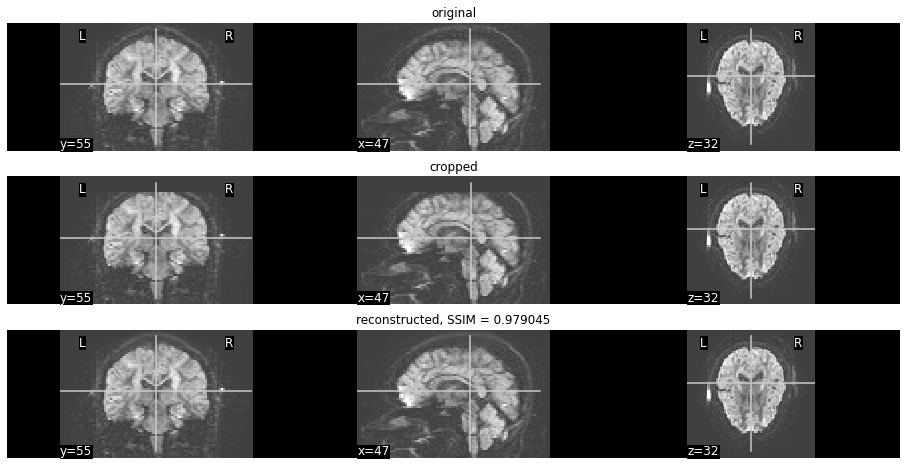

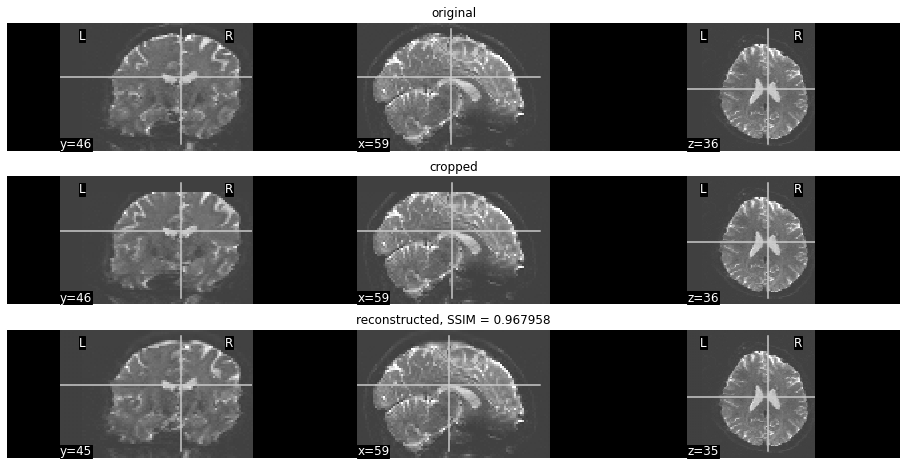

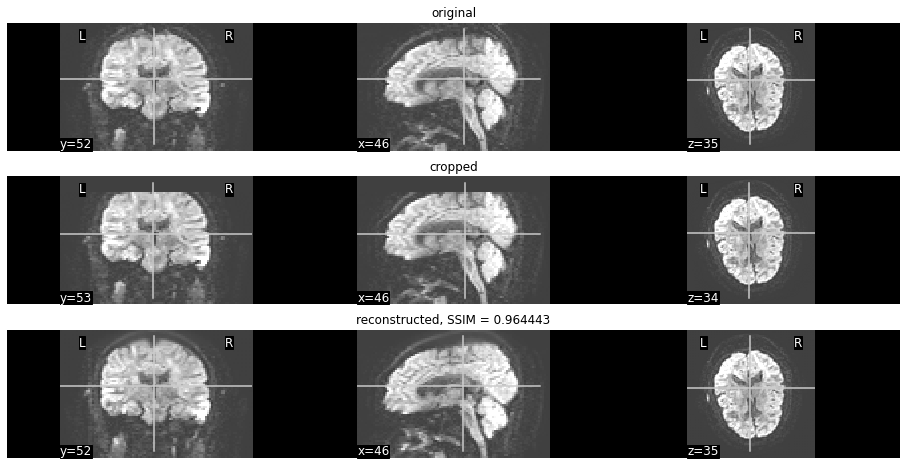

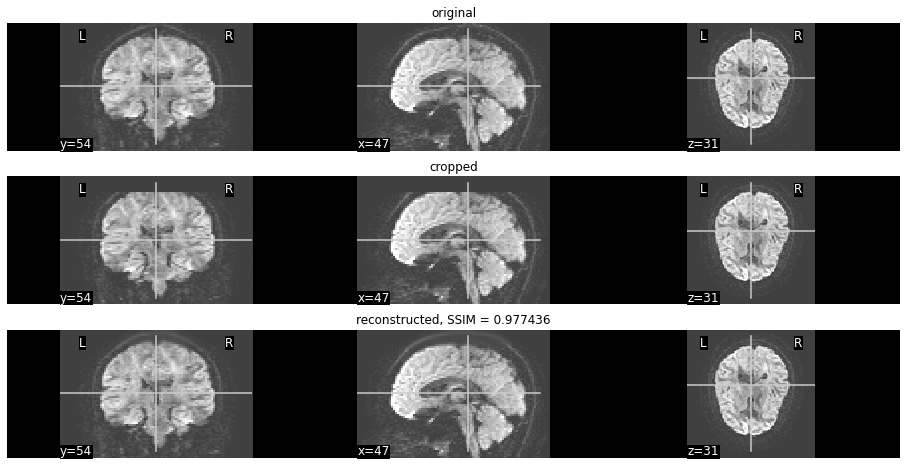

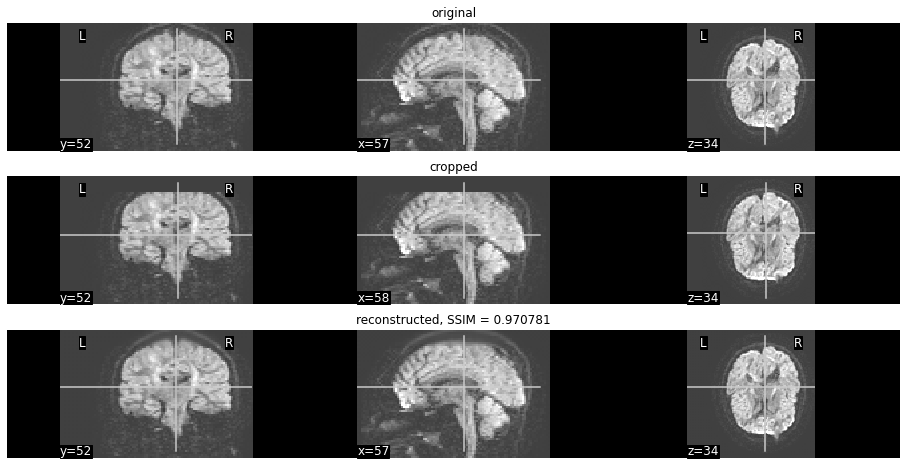

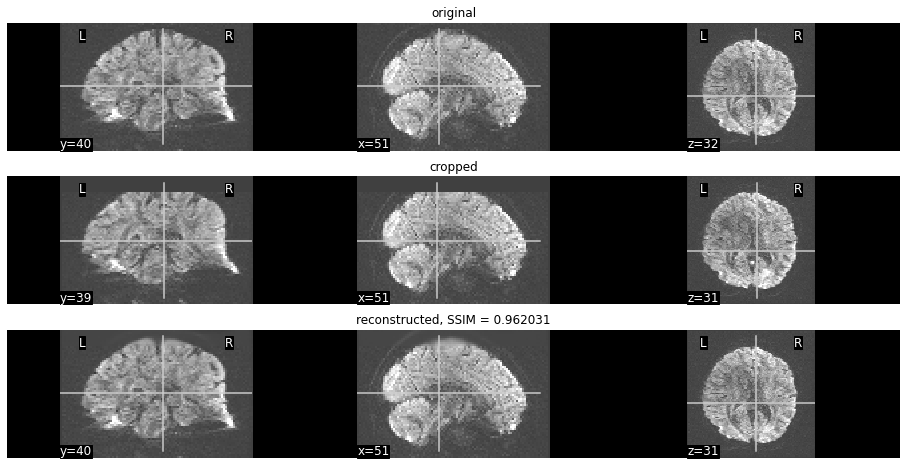

Average SSIM: 0.960064
STD SSIM: 0.021739


(0.9600636759673933, 0.021739180356546144)

In [7]:
test_model(model, validation_generator)

## Test on actual bad data

#### Load model

In [16]:
import torch
from torch.utils import data

from Dataset import Dataset
from Models import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
import pickle
import nibabel as nib
from nilearn.plotting import plot_anat
import os

# Load images
def loadb0(img_file, as_type = 'nib', normalize = True, resize = True):
    # as_type should either be nib for nibabel format or np for numpy array
    if as_type not in ['nib', 'np']:
        raise TypeError('Incorrect option for as_type. Use either nib or np.')
    # Load image
    img = nib.load(img_file)
    aff = img.affine
    img_fixed = img.get_fdata()
    # Normalize intensity to range of 0 to 1
    img_min = np.min(img_fixed, axis = (0,1,2))
    img_max = np.max(img_fixed, axis = (0,1,2))
    if normalize:
        img_fixed = (img_fixed - img_min) / (img_max - img_min)
    if resize:
        if img_fixed.shape[0] != 96:
            img_fixed = zoom(img_fixed, (0.75,0.75,1))
    if as_type == 'np':
        return img_fixed, aff, img_max, img_min
    elif as_type == 'nib':
        # Reform as image data type
        img_fixed = nib.Nifti1Image(img_fixed, aff)
        return img_fixed, aff, img_max, img_min

#### Reconstruct images

We can either translate the images down 8 voxels which we will reconstruct to maintain the same input size, but we risk cutting off parts of the cerebellum. Alternatively, we can keep the image as is, add 8 voxels of blank voxels, and have the model reconstruct 8 voxels on top of that, but then the input size is different from what the model has trained on.

In [12]:
dwi_files = np.loadtxt('ncanda/X_test_files.txt', dtype=str)
target_files = []
for file in dwi_files:
    folders = file.split('/')
    target_files.append('ncanda_fixed/' + '/'.join(folders[5:]))

model = torch.load('models/uvqvae.pth')
print(model)

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_skip(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): ConvTrans

/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'Models.VQVAE3D' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'model_parts.VQEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'model_parts.VQDecoder_skip' has changed. you can retrieve the original source code by accessing the object's source at

In [14]:
from scipy.ndimage import shift, zoom

def add_translation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
        
    shift_apply = np.zeros((3,))
    shift_apply[axis] = amount
    # Apply translation
    img_translated = shift(img, shift_apply)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_translated = nib.Nifti1Image(img_translated, image3d.affine)
        
    return img_translated

def denorm(img_arr, img_max, img_min):
    return img_arr * (img_max - img_min) + img_min

In [17]:
device = 'cuda:0'

model.eval()
model.to(device)
display_params = {'vmin': -0.1,
                  'vmax': 0.3,
                  'cut_coords': (0,0,20),
                  'draw_cross': False,
                  'annotate': False}

for ind, file in enumerate(dwi_files):
    #if ind < 679: continue
    print('Reconstructing %d of %d...' % ((ind+1), len(dwi_files)))
    dwi_in, aff, img_max, img_min = loadb0(file, as_type = 'np')
    # Translate image down
    cutoff = dwi_in[:,:,:8]
    dwi_shift = add_translation(dwi_in, -8, 2)        
    dwi_shift = torch.from_numpy(dwi_shift).view(1,1,dwi_shift.shape[0],dwi_shift.shape[1],dwi_shift.shape[2]).float()

    dwi_shift = dwi_shift.to(device)
    
    outputs = model(dwi_shift)
    plot_recon = outputs['x_out']
    dwi_recon = plot_recon.cpu().detach().numpy().squeeze()
    dwi_recon = np.concatenate((cutoff, dwi_recon), axis = 2)
    dwi_save = denorm(dwi_recon, img_max, img_min)
    dwi_shift = dwi_shift.cpu().detach().numpy().squeeze()
    
#     dwi = nib.load(file).get_fdata()
#     plt.close('all')
#     plt.hist(dwi_save.flatten(), bins = 50, color = 'lightsteelblue')
#     plt.hist(dwi.flatten(), bins = 50, color = 'cornflowerblue')
#     plt.yscale('log')
#     plt.xlabel('Voxel intensity')
#     plt.ylabel('Count')
#     plt.title('Image histograms')
#     plt.legend(['reconstructed', 'original'])
#     plt.show()
    
    dwi_recon = nib.Nifti1Image(dwi_recon, aff)
    dwi_in = nib.Nifti1Image(dwi_in, aff)
    dwi_shift = nib.Nifti1Image(dwi_shift, aff)
    dwi_save = nib.Nifti1Image(dwi_save, aff)

#     plt.close('all')
#     fig, ax = plt.subplots(3,1,figsize = (16,12))
#     plot_anat(dwi_in, axes = ax[0], **display_params)
#     plot_anat(dwi_shift, axes = ax[1], **display_params)
#     plot_anat(dwi_recon, axes = ax[2], **display_params)

#     ax[0].set_title('original')
#     ax[1].set_title('shifted')
#     ax[2].set_title('inpainted')
    #plt.savefig('ncanda/images/'+str(ind)+'.png', dpi = 300)
    #plt.show()
    
    target_dir = '/'.join(target_files[ind].split('/')[:-1])
    if not os.path.isdir(target_dir):
        os.makedirs(target_dir)
    nib.save(dwi_save, target_files[ind])
    #if i == num_plot: break

Reconstructing 1 of 5923...
Reconstructing 2 of 5923...
Reconstructing 3 of 5923...
Reconstructing 4 of 5923...
Reconstructing 5 of 5923...
Reconstructing 6 of 5923...
Reconstructing 7 of 5923...
Reconstructing 8 of 5923...
Reconstructing 9 of 5923...
Reconstructing 10 of 5923...
Reconstructing 11 of 5923...
Reconstructing 12 of 5923...
Reconstructing 13 of 5923...
Reconstructing 14 of 5923...
Reconstructing 15 of 5923...
Reconstructing 16 of 5923...
Reconstructing 17 of 5923...
Reconstructing 18 of 5923...
Reconstructing 19 of 5923...
Reconstructing 20 of 5923...
Reconstructing 21 of 5923...
Reconstructing 22 of 5923...
Reconstructing 23 of 5923...
Reconstructing 24 of 5923...
Reconstructing 25 of 5923...
Reconstructing 26 of 5923...
Reconstructing 27 of 5923...
Reconstructing 28 of 5923...
Reconstructing 29 of 5923...
Reconstructing 30 of 5923...
Reconstructing 31 of 5923...
Reconstructing 32 of 5923...
Reconstructing 33 of 5923...
Reconstructing 34 of 5923...
Reconstructing 35 of 59

Reconstructing 278 of 5923...
Reconstructing 279 of 5923...
Reconstructing 280 of 5923...
Reconstructing 281 of 5923...
Reconstructing 282 of 5923...
Reconstructing 283 of 5923...
Reconstructing 284 of 5923...
Reconstructing 285 of 5923...
Reconstructing 286 of 5923...
Reconstructing 287 of 5923...
Reconstructing 288 of 5923...
Reconstructing 289 of 5923...
Reconstructing 290 of 5923...
Reconstructing 291 of 5923...
Reconstructing 292 of 5923...
Reconstructing 293 of 5923...
Reconstructing 294 of 5923...
Reconstructing 295 of 5923...
Reconstructing 296 of 5923...
Reconstructing 297 of 5923...
Reconstructing 298 of 5923...
Reconstructing 299 of 5923...
Reconstructing 300 of 5923...
Reconstructing 301 of 5923...
Reconstructing 302 of 5923...
Reconstructing 303 of 5923...
Reconstructing 304 of 5923...
Reconstructing 305 of 5923...
Reconstructing 306 of 5923...
Reconstructing 307 of 5923...
Reconstructing 308 of 5923...
Reconstructing 309 of 5923...
Reconstructing 310 of 5923...
Reconstruc

Reconstructing 553 of 5923...
Reconstructing 554 of 5923...
Reconstructing 555 of 5923...
Reconstructing 556 of 5923...
Reconstructing 557 of 5923...
Reconstructing 558 of 5923...
Reconstructing 559 of 5923...
Reconstructing 560 of 5923...
Reconstructing 561 of 5923...
Reconstructing 562 of 5923...
Reconstructing 563 of 5923...
Reconstructing 564 of 5923...
Reconstructing 565 of 5923...
Reconstructing 566 of 5923...
Reconstructing 567 of 5923...
Reconstructing 568 of 5923...
Reconstructing 569 of 5923...
Reconstructing 570 of 5923...
Reconstructing 571 of 5923...
Reconstructing 572 of 5923...
Reconstructing 573 of 5923...
Reconstructing 574 of 5923...
Reconstructing 575 of 5923...
Reconstructing 576 of 5923...
Reconstructing 577 of 5923...
Reconstructing 578 of 5923...
Reconstructing 579 of 5923...
Reconstructing 580 of 5923...
Reconstructing 581 of 5923...
Reconstructing 582 of 5923...
Reconstructing 583 of 5923...
Reconstructing 584 of 5923...
Reconstructing 585 of 5923...
Reconstruc

Reconstructing 827 of 5923...
Reconstructing 828 of 5923...
Reconstructing 829 of 5923...
Reconstructing 830 of 5923...
Reconstructing 831 of 5923...
Reconstructing 832 of 5923...
Reconstructing 833 of 5923...
Reconstructing 834 of 5923...
Reconstructing 835 of 5923...
Reconstructing 836 of 5923...
Reconstructing 837 of 5923...
Reconstructing 838 of 5923...
Reconstructing 839 of 5923...
Reconstructing 840 of 5923...
Reconstructing 841 of 5923...
Reconstructing 842 of 5923...
Reconstructing 843 of 5923...
Reconstructing 844 of 5923...
Reconstructing 845 of 5923...
Reconstructing 846 of 5923...
Reconstructing 847 of 5923...
Reconstructing 848 of 5923...
Reconstructing 849 of 5923...
Reconstructing 850 of 5923...
Reconstructing 851 of 5923...
Reconstructing 852 of 5923...
Reconstructing 853 of 5923...
Reconstructing 854 of 5923...
Reconstructing 855 of 5923...
Reconstructing 856 of 5923...
Reconstructing 857 of 5923...
Reconstructing 858 of 5923...
Reconstructing 859 of 5923...
Reconstruc

Reconstructing 1098 of 5923...
Reconstructing 1099 of 5923...
Reconstructing 1100 of 5923...
Reconstructing 1101 of 5923...
Reconstructing 1102 of 5923...
Reconstructing 1103 of 5923...
Reconstructing 1104 of 5923...
Reconstructing 1105 of 5923...
Reconstructing 1106 of 5923...
Reconstructing 1107 of 5923...
Reconstructing 1108 of 5923...
Reconstructing 1109 of 5923...
Reconstructing 1110 of 5923...
Reconstructing 1111 of 5923...
Reconstructing 1112 of 5923...
Reconstructing 1113 of 5923...
Reconstructing 1114 of 5923...
Reconstructing 1115 of 5923...
Reconstructing 1116 of 5923...
Reconstructing 1117 of 5923...
Reconstructing 1118 of 5923...
Reconstructing 1119 of 5923...
Reconstructing 1120 of 5923...
Reconstructing 1121 of 5923...
Reconstructing 1122 of 5923...
Reconstructing 1123 of 5923...
Reconstructing 1124 of 5923...
Reconstructing 1125 of 5923...
Reconstructing 1126 of 5923...
Reconstructing 1127 of 5923...
Reconstructing 1128 of 5923...
Reconstructing 1129 of 5923...
Reconstr

Reconstructing 1363 of 5923...
Reconstructing 1364 of 5923...
Reconstructing 1365 of 5923...
Reconstructing 1366 of 5923...
Reconstructing 1367 of 5923...
Reconstructing 1368 of 5923...
Reconstructing 1369 of 5923...
Reconstructing 1370 of 5923...
Reconstructing 1371 of 5923...
Reconstructing 1372 of 5923...
Reconstructing 1373 of 5923...
Reconstructing 1374 of 5923...
Reconstructing 1375 of 5923...
Reconstructing 1376 of 5923...
Reconstructing 1377 of 5923...
Reconstructing 1378 of 5923...
Reconstructing 1379 of 5923...
Reconstructing 1380 of 5923...
Reconstructing 1381 of 5923...
Reconstructing 1382 of 5923...
Reconstructing 1383 of 5923...
Reconstructing 1384 of 5923...
Reconstructing 1385 of 5923...
Reconstructing 1386 of 5923...
Reconstructing 1387 of 5923...
Reconstructing 1388 of 5923...
Reconstructing 1389 of 5923...
Reconstructing 1390 of 5923...
Reconstructing 1391 of 5923...
Reconstructing 1392 of 5923...
Reconstructing 1393 of 5923...
Reconstructing 1394 of 5923...
Reconstr

Reconstructing 1629 of 5923...
Reconstructing 1630 of 5923...
Reconstructing 1631 of 5923...
Reconstructing 1632 of 5923...
Reconstructing 1633 of 5923...
Reconstructing 1634 of 5923...
Reconstructing 1635 of 5923...
Reconstructing 1636 of 5923...
Reconstructing 1637 of 5923...
Reconstructing 1638 of 5923...
Reconstructing 1639 of 5923...
Reconstructing 1640 of 5923...
Reconstructing 1641 of 5923...
Reconstructing 1642 of 5923...
Reconstructing 1643 of 5923...
Reconstructing 1644 of 5923...
Reconstructing 1645 of 5923...
Reconstructing 1646 of 5923...
Reconstructing 1647 of 5923...
Reconstructing 1648 of 5923...
Reconstructing 1649 of 5923...
Reconstructing 1650 of 5923...
Reconstructing 1651 of 5923...
Reconstructing 1652 of 5923...
Reconstructing 1653 of 5923...
Reconstructing 1654 of 5923...
Reconstructing 1655 of 5923...
Reconstructing 1656 of 5923...
Reconstructing 1657 of 5923...
Reconstructing 1658 of 5923...
Reconstructing 1659 of 5923...
Reconstructing 1660 of 5923...
Reconstr

Reconstructing 1894 of 5923...
Reconstructing 1895 of 5923...
Reconstructing 1896 of 5923...
Reconstructing 1897 of 5923...
Reconstructing 1898 of 5923...
Reconstructing 1899 of 5923...
Reconstructing 1900 of 5923...
Reconstructing 1901 of 5923...
Reconstructing 1902 of 5923...
Reconstructing 1903 of 5923...
Reconstructing 1904 of 5923...
Reconstructing 1905 of 5923...
Reconstructing 1906 of 5923...
Reconstructing 1907 of 5923...
Reconstructing 1908 of 5923...
Reconstructing 1909 of 5923...
Reconstructing 1910 of 5923...
Reconstructing 1911 of 5923...
Reconstructing 1912 of 5923...
Reconstructing 1913 of 5923...
Reconstructing 1914 of 5923...
Reconstructing 1915 of 5923...
Reconstructing 1916 of 5923...
Reconstructing 1917 of 5923...
Reconstructing 1918 of 5923...
Reconstructing 1919 of 5923...
Reconstructing 1920 of 5923...
Reconstructing 1921 of 5923...
Reconstructing 1922 of 5923...
Reconstructing 1923 of 5923...
Reconstructing 1924 of 5923...
Reconstructing 1925 of 5923...
Reconstr

Reconstructing 2159 of 5923...
Reconstructing 2160 of 5923...
Reconstructing 2161 of 5923...
Reconstructing 2162 of 5923...
Reconstructing 2163 of 5923...
Reconstructing 2164 of 5923...
Reconstructing 2165 of 5923...
Reconstructing 2166 of 5923...
Reconstructing 2167 of 5923...
Reconstructing 2168 of 5923...
Reconstructing 2169 of 5923...
Reconstructing 2170 of 5923...
Reconstructing 2171 of 5923...
Reconstructing 2172 of 5923...
Reconstructing 2173 of 5923...
Reconstructing 2174 of 5923...
Reconstructing 2175 of 5923...
Reconstructing 2176 of 5923...
Reconstructing 2177 of 5923...
Reconstructing 2178 of 5923...
Reconstructing 2179 of 5923...
Reconstructing 2180 of 5923...
Reconstructing 2181 of 5923...
Reconstructing 2182 of 5923...
Reconstructing 2183 of 5923...
Reconstructing 2184 of 5923...
Reconstructing 2185 of 5923...
Reconstructing 2186 of 5923...
Reconstructing 2187 of 5923...
Reconstructing 2188 of 5923...
Reconstructing 2189 of 5923...
Reconstructing 2190 of 5923...
Reconstr

Reconstructing 2424 of 5923...
Reconstructing 2425 of 5923...
Reconstructing 2426 of 5923...
Reconstructing 2427 of 5923...
Reconstructing 2428 of 5923...
Reconstructing 2429 of 5923...
Reconstructing 2430 of 5923...
Reconstructing 2431 of 5923...
Reconstructing 2432 of 5923...
Reconstructing 2433 of 5923...
Reconstructing 2434 of 5923...
Reconstructing 2435 of 5923...
Reconstructing 2436 of 5923...
Reconstructing 2437 of 5923...
Reconstructing 2438 of 5923...
Reconstructing 2439 of 5923...
Reconstructing 2440 of 5923...
Reconstructing 2441 of 5923...
Reconstructing 2442 of 5923...
Reconstructing 2443 of 5923...
Reconstructing 2444 of 5923...
Reconstructing 2445 of 5923...
Reconstructing 2446 of 5923...
Reconstructing 2447 of 5923...
Reconstructing 2448 of 5923...
Reconstructing 2449 of 5923...
Reconstructing 2450 of 5923...
Reconstructing 2451 of 5923...
Reconstructing 2452 of 5923...
Reconstructing 2453 of 5923...
Reconstructing 2454 of 5923...
Reconstructing 2455 of 5923...
Reconstr

Reconstructing 2689 of 5923...
Reconstructing 2690 of 5923...
Reconstructing 2691 of 5923...
Reconstructing 2692 of 5923...
Reconstructing 2693 of 5923...
Reconstructing 2694 of 5923...
Reconstructing 2695 of 5923...
Reconstructing 2696 of 5923...
Reconstructing 2697 of 5923...
Reconstructing 2698 of 5923...
Reconstructing 2699 of 5923...
Reconstructing 2700 of 5923...
Reconstructing 2701 of 5923...
Reconstructing 2702 of 5923...
Reconstructing 2703 of 5923...
Reconstructing 2704 of 5923...
Reconstructing 2705 of 5923...
Reconstructing 2706 of 5923...
Reconstructing 2707 of 5923...
Reconstructing 2708 of 5923...
Reconstructing 2709 of 5923...
Reconstructing 2710 of 5923...
Reconstructing 2711 of 5923...
Reconstructing 2712 of 5923...
Reconstructing 2713 of 5923...
Reconstructing 2714 of 5923...
Reconstructing 2715 of 5923...
Reconstructing 2716 of 5923...
Reconstructing 2717 of 5923...
Reconstructing 2718 of 5923...
Reconstructing 2719 of 5923...
Reconstructing 2720 of 5923...
Reconstr

Reconstructing 2954 of 5923...
Reconstructing 2955 of 5923...
Reconstructing 2956 of 5923...
Reconstructing 2957 of 5923...
Reconstructing 2958 of 5923...
Reconstructing 2959 of 5923...
Reconstructing 2960 of 5923...
Reconstructing 2961 of 5923...
Reconstructing 2962 of 5923...
Reconstructing 2963 of 5923...
Reconstructing 2964 of 5923...
Reconstructing 2965 of 5923...
Reconstructing 2966 of 5923...
Reconstructing 2967 of 5923...
Reconstructing 2968 of 5923...
Reconstructing 2969 of 5923...
Reconstructing 2970 of 5923...
Reconstructing 2971 of 5923...
Reconstructing 2972 of 5923...
Reconstructing 2973 of 5923...
Reconstructing 2974 of 5923...
Reconstructing 2975 of 5923...
Reconstructing 2976 of 5923...
Reconstructing 2977 of 5923...
Reconstructing 2978 of 5923...
Reconstructing 2979 of 5923...
Reconstructing 2980 of 5923...
Reconstructing 2981 of 5923...
Reconstructing 2982 of 5923...
Reconstructing 2983 of 5923...
Reconstructing 2984 of 5923...
Reconstructing 2985 of 5923...
Reconstr

Reconstructing 3219 of 5923...
Reconstructing 3220 of 5923...
Reconstructing 3221 of 5923...
Reconstructing 3222 of 5923...
Reconstructing 3223 of 5923...
Reconstructing 3224 of 5923...
Reconstructing 3225 of 5923...
Reconstructing 3226 of 5923...
Reconstructing 3227 of 5923...
Reconstructing 3228 of 5923...
Reconstructing 3229 of 5923...
Reconstructing 3230 of 5923...
Reconstructing 3231 of 5923...
Reconstructing 3232 of 5923...
Reconstructing 3233 of 5923...
Reconstructing 3234 of 5923...
Reconstructing 3235 of 5923...
Reconstructing 3236 of 5923...
Reconstructing 3237 of 5923...
Reconstructing 3238 of 5923...
Reconstructing 3239 of 5923...
Reconstructing 3240 of 5923...
Reconstructing 3241 of 5923...
Reconstructing 3242 of 5923...
Reconstructing 3243 of 5923...
Reconstructing 3244 of 5923...
Reconstructing 3245 of 5923...
Reconstructing 3246 of 5923...
Reconstructing 3247 of 5923...
Reconstructing 3248 of 5923...
Reconstructing 3249 of 5923...
Reconstructing 3250 of 5923...
Reconstr

Reconstructing 3484 of 5923...
Reconstructing 3485 of 5923...
Reconstructing 3486 of 5923...
Reconstructing 3487 of 5923...
Reconstructing 3488 of 5923...
Reconstructing 3489 of 5923...
Reconstructing 3490 of 5923...
Reconstructing 3491 of 5923...
Reconstructing 3492 of 5923...
Reconstructing 3493 of 5923...
Reconstructing 3494 of 5923...
Reconstructing 3495 of 5923...
Reconstructing 3496 of 5923...
Reconstructing 3497 of 5923...
Reconstructing 3498 of 5923...
Reconstructing 3499 of 5923...
Reconstructing 3500 of 5923...
Reconstructing 3501 of 5923...
Reconstructing 3502 of 5923...
Reconstructing 3503 of 5923...
Reconstructing 3504 of 5923...
Reconstructing 3505 of 5923...
Reconstructing 3506 of 5923...
Reconstructing 3507 of 5923...
Reconstructing 3508 of 5923...
Reconstructing 3509 of 5923...
Reconstructing 3510 of 5923...
Reconstructing 3511 of 5923...
Reconstructing 3512 of 5923...
Reconstructing 3513 of 5923...
Reconstructing 3514 of 5923...
Reconstructing 3515 of 5923...
Reconstr

Reconstructing 3749 of 5923...
Reconstructing 3750 of 5923...
Reconstructing 3751 of 5923...
Reconstructing 3752 of 5923...
Reconstructing 3753 of 5923...
Reconstructing 3754 of 5923...
Reconstructing 3755 of 5923...
Reconstructing 3756 of 5923...
Reconstructing 3757 of 5923...
Reconstructing 3758 of 5923...
Reconstructing 3759 of 5923...
Reconstructing 3760 of 5923...
Reconstructing 3761 of 5923...
Reconstructing 3762 of 5923...
Reconstructing 3763 of 5923...
Reconstructing 3764 of 5923...
Reconstructing 3765 of 5923...
Reconstructing 3766 of 5923...
Reconstructing 3767 of 5923...
Reconstructing 3768 of 5923...
Reconstructing 3769 of 5923...
Reconstructing 3770 of 5923...
Reconstructing 3771 of 5923...
Reconstructing 3772 of 5923...
Reconstructing 3773 of 5923...
Reconstructing 3774 of 5923...
Reconstructing 3775 of 5923...
Reconstructing 3776 of 5923...
Reconstructing 3777 of 5923...
Reconstructing 3778 of 5923...
Reconstructing 3779 of 5923...
Reconstructing 3780 of 5923...
Reconstr

Reconstructing 4014 of 5923...
Reconstructing 4015 of 5923...
Reconstructing 4016 of 5923...
Reconstructing 4017 of 5923...
Reconstructing 4018 of 5923...
Reconstructing 4019 of 5923...
Reconstructing 4020 of 5923...
Reconstructing 4021 of 5923...
Reconstructing 4022 of 5923...
Reconstructing 4023 of 5923...
Reconstructing 4024 of 5923...
Reconstructing 4025 of 5923...
Reconstructing 4026 of 5923...
Reconstructing 4027 of 5923...
Reconstructing 4028 of 5923...
Reconstructing 4029 of 5923...
Reconstructing 4030 of 5923...
Reconstructing 4031 of 5923...
Reconstructing 4032 of 5923...
Reconstructing 4033 of 5923...
Reconstructing 4034 of 5923...
Reconstructing 4035 of 5923...
Reconstructing 4036 of 5923...
Reconstructing 4037 of 5923...
Reconstructing 4038 of 5923...
Reconstructing 4039 of 5923...
Reconstructing 4040 of 5923...
Reconstructing 4041 of 5923...
Reconstructing 4042 of 5923...
Reconstructing 4043 of 5923...
Reconstructing 4044 of 5923...
Reconstructing 4045 of 5923...
Reconstr

Reconstructing 4279 of 5923...
Reconstructing 4280 of 5923...
Reconstructing 4281 of 5923...
Reconstructing 4282 of 5923...
Reconstructing 4283 of 5923...
Reconstructing 4284 of 5923...
Reconstructing 4285 of 5923...
Reconstructing 4286 of 5923...
Reconstructing 4287 of 5923...
Reconstructing 4288 of 5923...
Reconstructing 4289 of 5923...
Reconstructing 4290 of 5923...
Reconstructing 4291 of 5923...
Reconstructing 4292 of 5923...
Reconstructing 4293 of 5923...
Reconstructing 4294 of 5923...
Reconstructing 4295 of 5923...
Reconstructing 4296 of 5923...
Reconstructing 4297 of 5923...
Reconstructing 4298 of 5923...
Reconstructing 4299 of 5923...
Reconstructing 4300 of 5923...
Reconstructing 4301 of 5923...
Reconstructing 4302 of 5923...
Reconstructing 4303 of 5923...
Reconstructing 4304 of 5923...
Reconstructing 4305 of 5923...
Reconstructing 4306 of 5923...
Reconstructing 4307 of 5923...
Reconstructing 4308 of 5923...
Reconstructing 4309 of 5923...
Reconstructing 4310 of 5923...
Reconstr

Reconstructing 4545 of 5923...
Reconstructing 4546 of 5923...
Reconstructing 4547 of 5923...
Reconstructing 4548 of 5923...
Reconstructing 4549 of 5923...
Reconstructing 4550 of 5923...
Reconstructing 4551 of 5923...
Reconstructing 4552 of 5923...
Reconstructing 4553 of 5923...
Reconstructing 4554 of 5923...
Reconstructing 4555 of 5923...
Reconstructing 4556 of 5923...
Reconstructing 4557 of 5923...
Reconstructing 4558 of 5923...
Reconstructing 4559 of 5923...
Reconstructing 4560 of 5923...
Reconstructing 4561 of 5923...
Reconstructing 4562 of 5923...
Reconstructing 4563 of 5923...
Reconstructing 4564 of 5923...
Reconstructing 4565 of 5923...
Reconstructing 4566 of 5923...
Reconstructing 4567 of 5923...
Reconstructing 4568 of 5923...
Reconstructing 4569 of 5923...
Reconstructing 4570 of 5923...
Reconstructing 4571 of 5923...
Reconstructing 4572 of 5923...
Reconstructing 4573 of 5923...
Reconstructing 4574 of 5923...
Reconstructing 4575 of 5923...
Reconstructing 4576 of 5923...
Reconstr

Reconstructing 4810 of 5923...
Reconstructing 4811 of 5923...
Reconstructing 4812 of 5923...
Reconstructing 4813 of 5923...
Reconstructing 4814 of 5923...
Reconstructing 4815 of 5923...
Reconstructing 4816 of 5923...
Reconstructing 4817 of 5923...
Reconstructing 4818 of 5923...
Reconstructing 4819 of 5923...
Reconstructing 4820 of 5923...
Reconstructing 4821 of 5923...
Reconstructing 4822 of 5923...
Reconstructing 4823 of 5923...
Reconstructing 4824 of 5923...
Reconstructing 4825 of 5923...
Reconstructing 4826 of 5923...
Reconstructing 4827 of 5923...
Reconstructing 4828 of 5923...
Reconstructing 4829 of 5923...
Reconstructing 4830 of 5923...
Reconstructing 4831 of 5923...
Reconstructing 4832 of 5923...
Reconstructing 4833 of 5923...
Reconstructing 4834 of 5923...
Reconstructing 4835 of 5923...
Reconstructing 4836 of 5923...
Reconstructing 4837 of 5923...
Reconstructing 4838 of 5923...
Reconstructing 4839 of 5923...
Reconstructing 4840 of 5923...
Reconstructing 4841 of 5923...
Reconstr

Reconstructing 5076 of 5923...
Reconstructing 5077 of 5923...
Reconstructing 5078 of 5923...
Reconstructing 5079 of 5923...
Reconstructing 5080 of 5923...
Reconstructing 5081 of 5923...
Reconstructing 5082 of 5923...
Reconstructing 5083 of 5923...
Reconstructing 5084 of 5923...
Reconstructing 5085 of 5923...
Reconstructing 5086 of 5923...
Reconstructing 5087 of 5923...
Reconstructing 5088 of 5923...
Reconstructing 5089 of 5923...
Reconstructing 5090 of 5923...
Reconstructing 5091 of 5923...
Reconstructing 5092 of 5923...
Reconstructing 5093 of 5923...
Reconstructing 5094 of 5923...
Reconstructing 5095 of 5923...
Reconstructing 5096 of 5923...
Reconstructing 5097 of 5923...
Reconstructing 5098 of 5923...
Reconstructing 5099 of 5923...
Reconstructing 5100 of 5923...
Reconstructing 5101 of 5923...
Reconstructing 5102 of 5923...
Reconstructing 5103 of 5923...
Reconstructing 5104 of 5923...
Reconstructing 5105 of 5923...
Reconstructing 5106 of 5923...
Reconstructing 5107 of 5923...
Reconstr

Reconstructing 5341 of 5923...
Reconstructing 5342 of 5923...
Reconstructing 5343 of 5923...
Reconstructing 5344 of 5923...
Reconstructing 5345 of 5923...
Reconstructing 5346 of 5923...
Reconstructing 5347 of 5923...
Reconstructing 5348 of 5923...
Reconstructing 5349 of 5923...
Reconstructing 5350 of 5923...
Reconstructing 5351 of 5923...
Reconstructing 5352 of 5923...
Reconstructing 5353 of 5923...
Reconstructing 5354 of 5923...
Reconstructing 5355 of 5923...
Reconstructing 5356 of 5923...
Reconstructing 5357 of 5923...
Reconstructing 5358 of 5923...
Reconstructing 5359 of 5923...
Reconstructing 5360 of 5923...
Reconstructing 5361 of 5923...
Reconstructing 5362 of 5923...
Reconstructing 5363 of 5923...
Reconstructing 5364 of 5923...
Reconstructing 5365 of 5923...
Reconstructing 5366 of 5923...
Reconstructing 5367 of 5923...
Reconstructing 5368 of 5923...
Reconstructing 5369 of 5923...
Reconstructing 5370 of 5923...
Reconstructing 5371 of 5923...
Reconstructing 5372 of 5923...
Reconstr

Reconstructing 5606 of 5923...
Reconstructing 5607 of 5923...
Reconstructing 5608 of 5923...
Reconstructing 5609 of 5923...
Reconstructing 5610 of 5923...
Reconstructing 5611 of 5923...
Reconstructing 5612 of 5923...
Reconstructing 5613 of 5923...
Reconstructing 5614 of 5923...
Reconstructing 5615 of 5923...
Reconstructing 5616 of 5923...
Reconstructing 5617 of 5923...
Reconstructing 5618 of 5923...
Reconstructing 5619 of 5923...
Reconstructing 5620 of 5923...
Reconstructing 5621 of 5923...
Reconstructing 5622 of 5923...
Reconstructing 5623 of 5923...
Reconstructing 5624 of 5923...
Reconstructing 5625 of 5923...
Reconstructing 5626 of 5923...
Reconstructing 5627 of 5923...
Reconstructing 5628 of 5923...
Reconstructing 5629 of 5923...
Reconstructing 5630 of 5923...
Reconstructing 5631 of 5923...
Reconstructing 5632 of 5923...
Reconstructing 5633 of 5923...
Reconstructing 5634 of 5923...
Reconstructing 5635 of 5923...
Reconstructing 5636 of 5923...
Reconstructing 5637 of 5923...
Reconstr

Reconstructing 5871 of 5923...
Reconstructing 5872 of 5923...
Reconstructing 5873 of 5923...
Reconstructing 5874 of 5923...
Reconstructing 5875 of 5923...
Reconstructing 5876 of 5923...
Reconstructing 5877 of 5923...
Reconstructing 5878 of 5923...
Reconstructing 5879 of 5923...
Reconstructing 5880 of 5923...
Reconstructing 5881 of 5923...
Reconstructing 5882 of 5923...
Reconstructing 5883 of 5923...
Reconstructing 5884 of 5923...
Reconstructing 5885 of 5923...
Reconstructing 5886 of 5923...
Reconstructing 5887 of 5923...
Reconstructing 5888 of 5923...
Reconstructing 5889 of 5923...
Reconstructing 5890 of 5923...
Reconstructing 5891 of 5923...
Reconstructing 5892 of 5923...
Reconstructing 5893 of 5923...
Reconstructing 5894 of 5923...
Reconstructing 5895 of 5923...
Reconstructing 5896 of 5923...
Reconstructing 5897 of 5923...
Reconstructing 5898 of 5923...
Reconstructing 5899 of 5923...
Reconstructing 5900 of 5923...
Reconstructing 5901 of 5923...
Reconstructing 5902 of 5923...
Reconstr

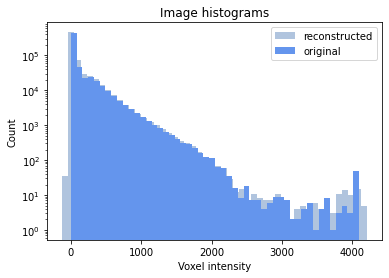

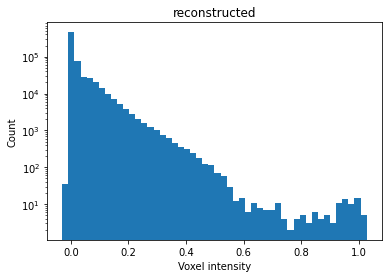

In [32]:
dwi = nib.load(dwi_files[0]).get_fdata()
plt.close('all')
plt.hist(dwi_save.flatten(), bins = 50, color = 'lightsteelblue')
plt.hist(dwi.flatten(), bins = 50, color = 'cornflowerblue')
plt.yscale('log')
plt.xlabel('Voxel intensity')
plt.ylabel('Count')
plt.title('Image histograms')
plt.legend(['reconstructed', 'original'])
plt.show()

plt.close('all')
plt.hist(dwi_recon.flatten(), bins = 50)
plt.yscale('log')
plt.xlabel('Voxel intensity')
plt.ylabel('Count')
plt.title('reconstructed')
plt.show()

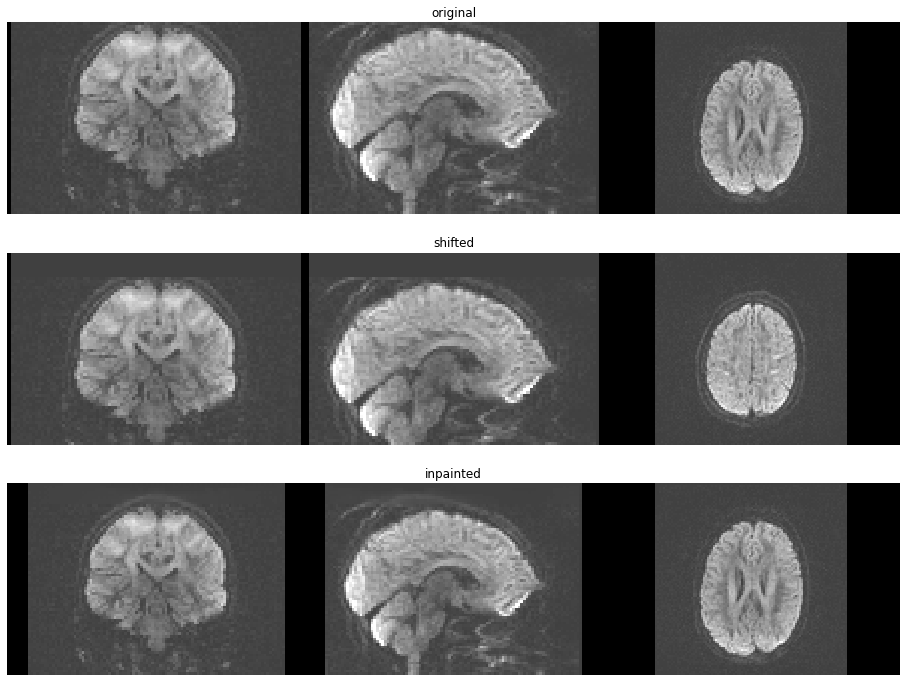

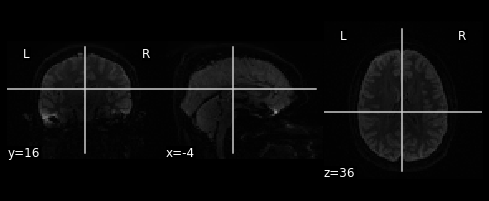

In [10]:
img_in = nib.load(dwi_files[4])
img_out = nib.load(target_files[4])
plt.close('all')
plot_anat(img_out)
plt.show()

## Apply models on varied cropping

In [1]:
import torch
from torch.utils import data

from Dataset import Dataset
from Models import *

import numpy as np
import matplotlib.pyplot as plt
import pickle
import nibabel as nib
from nilearn.plotting import plot_anat
from skimage.metrics import structural_similarity

import matplotlib as mpl

mpl.use('nbagg')

plt.style.use('publication.mplstyle')

batch_size = 64
cpu_batch_load_workers = 0
valid_corrupt_prob = 1.0
max_corrupt = 32

params = {'batch_size': batch_size,
          'shuffle': False,
          'num_workers': cpu_batch_load_workers}

paths = ['models/unet.pth',
         'models/uvqvae.pth',
         'models/vqvae.pth',
         'models/vaegan.pth']

models = ['U-Net', 'U-VQVAE', 'VQVAE', 'VAE-GAN']

folder2name = {'unet': 'U-Net',
               'uvqvae': 'U-VQVAE',
               'vqvae': 'VQVAE',
               'vaegan': 'VAE-GAN'}
    
dwi_files1 = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files2 = np.loadtxt('X_resized_files.txt', dtype=str)
dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
np.random.seed(420)
np.random.shuffle(dwi_files_npy)
num_train = int(0.8 * dwi_files_npy.shape[0])

input_shape = (1,96,96,64)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [4]:
def calculate_psnr(img_orig, img_recon):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    img1 = np.array(img_orig, dtype=np.float32)
    img2 = np.array(img_recon, dtype=np.float32)
    max_value = np.amax(img1)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

def mean_absolute_error(img_orig, img_recon):
    img1 = np.array(img_orig, dtype=np.float32)
    img2 = np.array(img_recon, dtype=np.float32)
    return np.mean(np.absolute((img1 - img2)))

def mean_squared_error(img_orig, img_recon):
    img1 = np.array(img_orig, dtype=np.float32)
    img2 = np.array(img_recon, dtype=np.float32)
    return np.mean((img1 - img2)**2)

def image_gradient(x):
    left = np.array(x)
    right = np.pad(x[:,:,1:], ((0,0),(0,0),(0,1)))
    bottom = np.array(x)
    top = np.pad(x[:,1:,:], ((0,0),(0,1),(0,0)))
    back = np.array(x)
    front = np.pad(x[1:,:,:], ((0,1),(0,0),(0,0)))
    
    gradient = np.sqrt((right - left)**2 + (top - bottom)**2 + (front - back)**2)
    
    return gradient

# Each measure has a dict keyed by each of the models, and the values are lists of tuples,
# where the tuple is the mean value for that measure with number of cropped voxels corresponding to
# same index in cropping list. Second value in tuple is STD
results = {'cropping': list(range(1, max_corrupt + 1)),
           'MSE': {name : {'whole': [], 'cropped': [], 'half': []} for name in models},
           'SSIM': {name : {'whole': [], 'cropped': [], 'half': []} for name in models},
           'PSNR': {name : {'whole': [], 'cropped': [], 'half': []} for name in models},
           'image_gradient': {name : {'whole': [], 'cropped': [], 'half': []} for name in models}}

# with open('varied_cropping.p', 'rb') as f:
#     results = pickle.load(f)

In [5]:
from collections import defaultdict

for ind,modelpath in enumerate(paths):
    #if ind < 3: continue
    modelname = folder2name[modelpath.split('/')[1].split('.')[0]]
    print(modelname)
    torch.cuda.empty_cache()
    
    model = torch.load(modelpath)
    model.eval()
    model.to(device)
    for num_corrupt in range(1, max_corrupt + 1):
        print('Cropping %d voxels' % num_corrupt)
        if 'generator' in modelpath:
            validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, num_corrupt = num_corrupt, tanh_norm = True)
        else:
            validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, num_corrupt = num_corrupt)
        
        validation_generator = data.DataLoader(validation_set, **params)

        ssim = {'whole': [], 'cropped': [], 'half': []}
        psnr = {'whole': [], 'cropped': [], 'half': []}
        mae = {'whole': [], 'cropped': [], 'half': []}
        mse = {'whole': [], 'cropped': [], 'half': []}
        gradient = {'whole': [], 'cropped': [], 'half': []}
        clean_gradient = {'whole': [], 'cropped': [], 'half': []}
        
        for batch_num, (plot_batch_in, plot_batch_out) in enumerate(validation_generator):
            if batch_num > 1: break
            plot_batch_in, plot_batch_out = plot_batch_in.to(device), plot_batch_out.to(device)

            outputs = model(plot_batch_in)
            plot_recon = outputs['x_out']

            x_recon = plot_recon.cpu().detach().numpy().squeeze()
            x_clean = plot_batch_out.cpu().detach().numpy().squeeze()
            if 'generator' in modelpath:
                x_recon = (x_recon + 1) / 2
                x_clean = (x_clean + 1) / 2
                
            data_range = np.max(x_clean) - np.min(x_clean)


            for i in range(batch_size):
                ssim['whole'].append(structural_similarity(x_clean[i], x_recon[i], data_range = data_range))
                ssim['half'].append(structural_similarity(x_clean[i][:,:,-max_corrupt:], x_recon[i][:,:,-max_corrupt:], data_range = data_range))
                if num_corrupt > 7:
                    ssim['cropped'].append(structural_similarity(x_clean[i][:,:,-num_corrupt:], x_recon[i][:,:,-num_corrupt:], data_range = data_range))
                else:
                    ssim['cropped'].append(0)
                psnr['cropped'].append(calculate_psnr(x_clean[i][:,:,-num_corrupt:], x_recon[i][:,:,-num_corrupt:]))
                psnr['half'].append(calculate_psnr(x_clean[i][:,:,-max_corrupt:], x_recon[i][:,:,-max_corrupt:]))
                psnr['whole'].append(calculate_psnr(x_clean[i], x_recon[i]))
#                 mae['cropped'].append(mean_absolute_error(x_clean[i][:,:,-num_corrupt:], x_recon[i][:,:,-num_corrupt:]))
#                 mae['half'].append(mean_absolute_error(x_clean[i][:,:,-max_corrupt:], x_recon[i][:,:,-max_corrupt:]))
#                 mae['whole'].append(mean_absolute_error(x_clean[i], x_recon[i]))
                mse['cropped'].append(mean_squared_error(x_clean[i][:,:,-num_corrupt:], x_recon[i][:,:,-num_corrupt:]))
                mse['half'].append(mean_squared_error(x_clean[i][:,:,-max_corrupt:], x_recon[i][:,:,-max_corrupt:]))
                mse['whole'].append(mean_squared_error(x_clean[i], x_recon[i]))
                gradient['cropped'].append(image_gradient(x_recon[i][:,:,-num_corrupt:]))
                gradient['half'].append(image_gradient(x_recon[i][:,:,-max_corrupt:]))
                gradient['whole'].append(image_gradient(x_recon[i]))
                if num_corrupt == 8:
                    clean_gradient['cropped'].append(image_gradient(x_clean[i][:,:,-num_corrupt:]))
                    clean_gradient['half'].append(image_gradient(x_clean[i][:,:,-max_corrupt:]))
                    clean_gradient['whole'].append(image_gradient(x_clean[i]))
            
        if num_corrupt == 8:
            results['image_gradient']['original'] = {'whole': np.mean(clean_gradient['whole'], axis = 0), 
                                                     'cropped': np.mean(clean_gradient['cropped'], axis = 0),
                                                     'half': np.mean(clean_gradient['half'], axis = 0)}
                

        for area in ['whole', 'cropped', 'half']:
#             results['MAE'][modelname][area].append((np.mean(mae[area]), np.std(mae[area])))
            results['MSE'][modelname][area].append((np.mean(mse[area]), np.std(mse[area])))
            results['SSIM'][modelname][area].append((np.mean(ssim[area]), np.std(ssim[area])))
            results['PSNR'][modelname][area].append((np.mean(psnr[area]), np.std(psnr[area])))
            results['image_gradient'][modelname][area].append(np.mean(gradient[area], axis = 0))
        
    with open('varied_cropping.p', 'wb') as f:
        pickle.dump(results, f)

U-Net
Cropping 1 voxels
Cropping 2 voxels
Cropping 3 voxels
Cropping 4 voxels
Cropping 5 voxels
Cropping 6 voxels
Cropping 7 voxels
Cropping 8 voxels
Cropping 9 voxels
Cropping 10 voxels
Cropping 11 voxels
Cropping 12 voxels
Cropping 13 voxels
Cropping 14 voxels
Cropping 15 voxels
Cropping 16 voxels
Cropping 17 voxels
Cropping 18 voxels
Cropping 19 voxels
Cropping 20 voxels
Cropping 21 voxels
Cropping 22 voxels
Cropping 23 voxels
Cropping 24 voxels
Cropping 25 voxels
Cropping 26 voxels
Cropping 27 voxels
Cropping 28 voxels
Cropping 29 voxels
Cropping 30 voxels
Cropping 31 voxels
Cropping 32 voxels
U-VQVAE
Cropping 1 voxels


/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'Models.VQVAE3D' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'model_parts.VQEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'model_parts.VQDecoder_skip' has changed. you can retrieve the original source code by accessing the object's source at

Cropping 2 voxels
Cropping 3 voxels
Cropping 4 voxels
Cropping 5 voxels
Cropping 6 voxels
Cropping 7 voxels
Cropping 8 voxels
Cropping 9 voxels
Cropping 10 voxels
Cropping 11 voxels
Cropping 12 voxels
Cropping 13 voxels
Cropping 14 voxels
Cropping 15 voxels
Cropping 16 voxels
Cropping 17 voxels
Cropping 18 voxels
Cropping 19 voxels
Cropping 20 voxels
Cropping 21 voxels
Cropping 22 voxels
Cropping 23 voxels
Cropping 24 voxels
Cropping 25 voxels
Cropping 26 voxels
Cropping 27 voxels
Cropping 28 voxels
Cropping 29 voxels
Cropping 30 voxels
Cropping 31 voxels
Cropping 32 voxels
VQVAE
Cropping 1 voxels


/home/users/rafiayub/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'model_parts.VQDecoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Cropping 2 voxels
Cropping 3 voxels
Cropping 4 voxels
Cropping 5 voxels
Cropping 6 voxels
Cropping 7 voxels
Cropping 8 voxels
Cropping 9 voxels
Cropping 10 voxels
Cropping 11 voxels
Cropping 12 voxels
Cropping 13 voxels
Cropping 14 voxels
Cropping 15 voxels
Cropping 16 voxels
Cropping 17 voxels
Cropping 18 voxels
Cropping 19 voxels
Cropping 20 voxels
Cropping 21 voxels
Cropping 22 voxels
Cropping 23 voxels
Cropping 24 voxels
Cropping 25 voxels
Cropping 26 voxels
Cropping 27 voxels
Cropping 28 voxels
Cropping 29 voxels
Cropping 30 voxels
Cropping 31 voxels
Cropping 32 voxels
VAE-GAN
Cropping 1 voxels
Cropping 2 voxels
Cropping 3 voxels
Cropping 4 voxels
Cropping 5 voxels
Cropping 6 voxels
Cropping 7 voxels
Cropping 8 voxels
Cropping 9 voxels
Cropping 10 voxels
Cropping 11 voxels
Cropping 12 voxels
Cropping 13 voxels
Cropping 14 voxels
Cropping 15 voxels
Cropping 16 voxels
Cropping 17 voxels
Cropping 18 voxels
Cropping 19 voxels
Cropping 20 voxels
Cropping 21 voxels
Cropping 22 voxels
Cr

In [ ]:
with open('varied_cropping.p', 'rb') as f:
    results = pickle.load(f)
    
models = ['VQVAE', 'U-VQVAE', 'U-Net', 'VAE-GAN']

for measure in ['SSIM', 'PSNR', 'MSE', 'image_gradient']:
    for area in ['whole', 'cropped', 'half']:
        print('%s %s:' % (measure, area))
        for modelname in models:
            if measure == 'image_gradient':
                print('\t%s: (%.8f, %.8f)' % (modelname, np.mean(results[measure][modelname][area][7]), np.std(results[measure][modelname][area][7])))
            else:
                print('\t%s: (%.8f, %.8f)' % (modelname, results[measure][modelname][area][7][0], results[measure][modelname][area][7][1]))